<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: Арсений Кравченко, DS team lead @ Juno. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №6
## <center> Исследование признаков на примере поездок такси в Чикаго

Чтобы начать работу, нужно скачать данные о поездках на такси в Чикаго за первые три месяца 2016 года, а также файл `column_remapping.json` и положить их в папку `data` в репозитории (комитить эти файлы не рекомендуется – они немаленькие).

Данные доступны на Kaggle в [этом](https://www.kaggle.com/chicago/chicago-taxi-rides-2016) соревновании. Описание данных [тут](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1yQkyn-FoutHi5BzSHq_YVNdN6ZGJe6za4y018nAi5UM).

In [1]:
RANDOM_STATE = 42
N_FOLDS = 5

In [2]:
import json
from glob import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

Будем играть с предсказанием цены, `fare` будет целевой переменной, тогда `trip_total` является ликом по отношению к ней – выкинем этот признак.

In [172]:
dataset_files = sorted(glob('../../data/chicago_taxi_trips_2016_*.csv'))
assert len(dataset_files) == 3

df = pd.concat(map(pd.read_csv, dataset_files))
df.drop('trip_total', axis=1, inplace=True)
target = df.pop('fare')

Загрузим словарь, ключи которого – названия признаков, а значения – опять же, словари, отображающие индексы уникальных значений признака в сами значения. Если звучит путано, посмотрите, например, на признак `pickup_longitude` в исходных данных и в словаре `column_remapping`.

In [173]:
with open('../../data/column_remapping.json') as json_file:
    column_remapping = json.load(json_file)

In [174]:
column_remapping.keys()

dict_keys(['taxi_id', 'company', 'pickup_census_tract', 'dropoff_census_tract', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

In [175]:
df.head()

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,tips,tolls,extras,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,85.0,2016-1-13 06:15:00,2016-1-13 06:15:00,180.0,0.40,NaN,NaN,24.0,24.0,0.00,0.0,0.0,Cash,107.0,199.0,510.0,199.0,510.0
1,2776.0,2016-1-22 09:30:00,2016-1-22 09:45:00,240.0,0.70,NaN,NaN,NaN,NaN,4.45,0.0,0.0,Credit Card,NaN,NaN,NaN,NaN,NaN
2,3168.0,2016-1-31 21:30:00,2016-1-31 21:30:00,0.0,0.00,NaN,NaN,NaN,NaN,5.00,0.0,0.0,Credit Card,119.0,NaN,NaN,NaN,NaN
3,4237.0,2016-1-23 17:30:00,2016-1-23 17:30:00,480.0,1.10,NaN,NaN,6.0,6.0,0.00,0.0,0.0,Cash,NaN,686.0,500.0,686.0,500.0
4,5710.0,2016-1-14 05:45:00,2016-1-14 06:00:00,480.0,2.71,NaN,NaN,32.0,NaN,0.00,0.0,0.0,Cash,NaN,385.0,478.0,NaN,NaN


In [7]:
assert df.shape == (5432105, 18)

In [168]:
target[df.tips.isnull()].isnull().sum()

57

In [183]:
df.trip_miles.max()

3280.0

In [8]:
column_remapping['dropoff_latitude']

{'0': '41.941422478',
 '1': '41.920265121',
 '10': '41.697269192',
 '100': '41.892658108',
 '101': '41.799291853',
 '102': '41.980606166',
 '103': '41.950077635',
 '104': '41.895257643',
 '105': '41.820104691',
 '106': '41.892276708',
 '107': '41.960675697',
 '108': '41.877044213',
 '109': '41.947791586',
 '11': '41.994498038',
 '110': '42.016010564',
 '111': '41.703280265',
 '112': '41.776408793',
 '113': '41.660493246',
 '114': '41.806765271',
 '115': '41.800260095',
 '116': '41.94258518',
 '117': '41.796205914',
 '118': '41.798605405',
 '119': '41.934986854',
 '12': '41.86958386',
 '120': '41.735123264',
 '121': '41.779954269',
 '122': '41.747534263',
 '123': '41.856333217',
 '124': '41.660136051',
 '125': '41.994266094',
 '126': '41.82371281',
 '127': '41.91213208',
 '128': '41.794972168',
 '129': '41.832937181',
 '13': '41.905693424',
 '130': '41.905857769',
 '131': '41.900560384',
 '132': '41.836510322',
 '133': '41.883793487',
 '134': '41.814440937',
 '135': '41.833517886',
 '13

**<font color='red'>Вопрос №1.</font> Какой из признаков является вещественным и из предобработки требует только заполнения/удаления пропусков? **

- dropoff_latitude
- **tips - OK**
- company
- pickup_census_tract

**<font color='red'>Вопрос №2.</font> Какие методы предобработки целевой переменной могут быть уместны, судя по графику? **

- возведение в n-ую степень, n >= 2 
- ride2vec
- **логарифмирование - OK**
- никакие

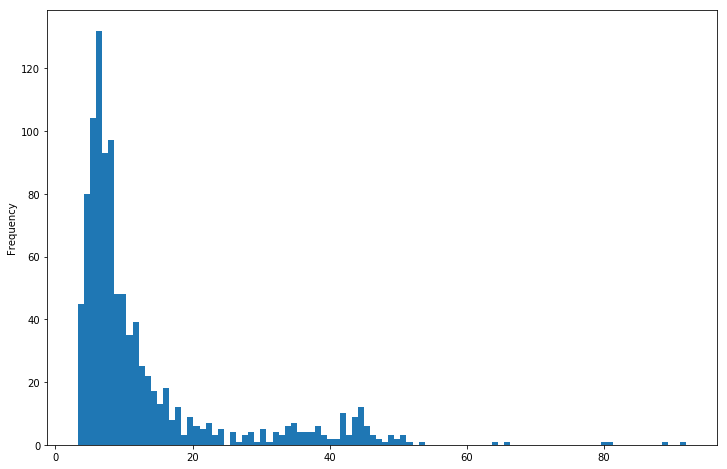

In [9]:
target.sample(1000, random_state=RANDOM_STATE).plot(kind='hist', bins=100);

**<font color='red'>Вопрос №3.</font> Каково максимальное расстояние (`great-circle distance` из библиотеки `geopy`, в км) между точками `pickup` и `dropoff`?** <br>(Для ускорения подсчета можно использовать `joblib`)
- 27.23
- 19.91
- 23.52
- **43.66 - OK**

In [10]:
# !pip install geopy
# !pip install joblib

In [11]:
from joblib import Parallel, delayed

In [12]:
# %%timeit
# # ПРИМЕР

# from math import sqrt
# np.max((Parallel(n_jobs=2)(delayed(sqrt)(i**3) for i in range(10))))

1 loop, best of 3: 1.45 s per loop


In [13]:
from geopy.distance import great_circle

In [14]:
# # ПРИМЕР
# newport_ri = (41.49008, -71.312796)
# cleveland_oh = (41.499498, -81.695391)
# print(great_circle(newport_ri, cleveland_oh).km)

864.45676162966


In [16]:
pickup_dropoff = df[['pickup_latitude', 'pickup_longitude', 
                     'dropoff_latitude', 'dropoff_longitude']].dropna()

In [18]:
pickup_dropoff['distance'] = pd.Series(np.zeros(len(pickup_dropoff)))

In [19]:
%%timeit
# пример расчета 1 дистанции
def coord(coord, i):
    return column_remapping[coord][str(int(pickup_dropoff[coord].iloc[i]))]
i = 2
pickup_coord = (coord('pickup_latitude', i), 
                    coord('pickup_longitude', i))
dropoff_coord = (coord('dropoff_latitude', i), 
                    coord('dropoff_longitude', i))
    
pickup_dropoff['distance'].iloc[i] = great_circle(pickup_coord, dropoff_coord).km 

The slowest run took 29.25 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 4.97 ms per loop


In [73]:
%%time
# максимальная дистанция без запоминания всех дистанций
def coord(coord, i):
    return column_remapping[coord][str(int(pickup_dropoff[coord].iloc[i]))]

#pickup_dropoff['distance'] = pd.Series(np.zeros(len(pickup_dropoff)))
max_distance = 0
for i in range(len(pickup_dropoff)):
    pickup_coord = (coord('pickup_latitude', i), 
                    coord('pickup_longitude', i))
    dropoff_coord = (coord('dropoff_latitude', i), 
                    coord('dropoff_longitude', i))
    
    #pickup_dropoff['distance'].iloc[i] = great_circle(pickup_coord, dropoff_coord).km
    distance = great_circle(pickup_coord, dropoff_coord).km
    if distance > max_distance:
        max_distance = distance

Wall time: 9min 10s


In [74]:
max_distance

43.662892734777216

посчитать и запомнить в массив ВСЕ дистанции так и не получилось, скорее всего из-за нехватки памяти (см. следующие 2 ячейки)

Давайте обучим простую модель, прежде чем пробовать добавлять признаки.

In [80]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    y_data = target.fillna(0)
    
kfold = KFold(n_splits=N_FOLDS, shuffle=True)
# np.abs тут нужен,т.к. sklearn по ошибке возвращает отрицательную MSE
print(np.abs(cross_val_score(LinearRegression(), 
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error')\
    .mean()))

923.297325563
Wall time: 8.31 s


**<font color='red'>Вопрос №4.</font> В ячейке выше допущено несколько ошибок и неаккуратных действий.
Что из перечисленных НЕ является проблемой, влияющей на настоящее качество модели? **

- **не зафиксирован random seed - OK**
- признаки разной размерности не нормированы
- взята малая подвыборка признаков
- пропуски в целевой переменной заполнены неуместным значением по умолчанию

Слегка модифицируем обработку данных.

In [81]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean())

877.71181818822151

In [115]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

for feat in ['tips', 'tolls', 'trip_seconds', 'trip_miles']:
    
    pipeline = make_pipeline(StandardScaler(),
                             LinearRegression())

    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    print('без %s: MSE = %f' % (feat, np.abs(cross_val_score(pipeline,
                    X=X_data.drop(feat, axis=1).values,
                    y=y_data,
                    cv=kfold,
                    scoring='neg_mean_squared_error') \
        .mean())))

без tips: MSE = 908.722836
без tolls: MSE = 719.773903
без trip_seconds: MSE = 905.274108
без trip_miles: MSE = 879.313958


**<font color='red'>Вопрос №5.</font> Какой из признаков нужно убрать, чтобы качество модели улучшилось значительнее всего?**

- tips
- **tolls - OK** 
- trip_seconds
- trip_miles
- ни один из вышеперечисленных

Давайте построим модель на двух признаках (время поездки и пройденное расстояние) и попробуем добавить еще один признак, связанный с датой. 

In [176]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['trip_start_timestamp', 'trip_seconds', 'trip_miles']]
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

timestamp = pd.to_datetime(X_data.pop('trip_start_timestamp'))

t1 = timestamp.apply(lambda x: x.dayofweek)
t2 = timestamp.apply(lambda x: 1 if x.dayofweek in (5, 6) else 0)
t3 = timestamp.apply(lambda x: x.hour)
t4 = timestamp.apply(lambda x: x.dayofweek * 24 + x.hour)

Wall time: 2min 14s


In [177]:
pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean())

748.90456534507416

In [106]:
for i, t in enumerate((t1, t2, t3, t4)):
    X_data_changed = X_data.copy()
    X_data_changed['time'] = t
    
    # Ваш код здесь
    pipeline = make_pipeline(StandardScaler(), 
                             LinearRegression())
    pipeline1 = make_pipeline(StandardScaler(), 
                             LinearRegression())

    kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    print('t%i: MSE (без ''time'') = %f, MSE (c ''time'') = %f' %(i+1, np.abs(cross_val_score(pipeline,
                    X=X_data_changed.drop('time', axis=1).values,
                    y=y_data,
                    cv=kfold,
                    scoring='neg_mean_squared_error').mean()), 
                    np.abs(cross_val_score(pipeline1,
                    X=X_data_changed.values,
                    y=y_data,
                    cv=kfold,
                    scoring='neg_mean_squared_error').mean())))

t1: MSE (без time) = 748.904565, MSE (c time) = 748.830518
t2: MSE (без time) = 748.904565, MSE (c time) = 748.894393
t3: MSE (без time) = 748.904565, MSE (c time) = 748.904921
t4: MSE (без time) = 748.904565, MSE (c time) = 748.829605


In [111]:
X_data_changed = X_data.copy()
X_data_changed['time'] = t4
X_data_changed.head(10)

,trip_seconds,trip_miles,time
0,180.0,0.40,54
1,240.0,0.70,105
2,0.0,0.00,165
3,480.0,1.10,137
4,480.0,2.71,77
5,1080.0,6.20,114
6,1500.0,18.40,76
7,60.0,0.20,28
8,180.0,0.00,107
9,0.0,0.00,93


** <font color='red'>Вопрос №6.</font> Какие выводы можно сделать? **

- новые признаки не улучшают модель, т.к. автор намеренно совершил техническую ошибку
- **новые признаки не улучшают модель, т.к. такова природа данных -OK**
- новые признаки улучшают модель всего на 3%
- новые признаки улучшают модель всего на 7%

** <font color='red'>Вопрос №7</font>. Отвлечемся и пофантазируем. Представим, что ввели закон, обязывающий пассажиров такси фотографировать своего водителя перед каждой поездкой и после каждой поездки; к нам, в дополнение к текущему датасету, попали эти фотографии. Как _нельзя_ было бы использовать их в предсказании цены поездки? **

- **извлечь признаки водителя при помощи предобученной нейронной сети, получив значения на одном из последних полносвязных слоев - OK**
- использовать метаданные о модели телефона пассажира
- использовать геотег с обеих фотографий
- использовать время съемки

Давайте попробуем преобразовать один из признаков, чтобы избавиться от "длинного хвоста" справа.

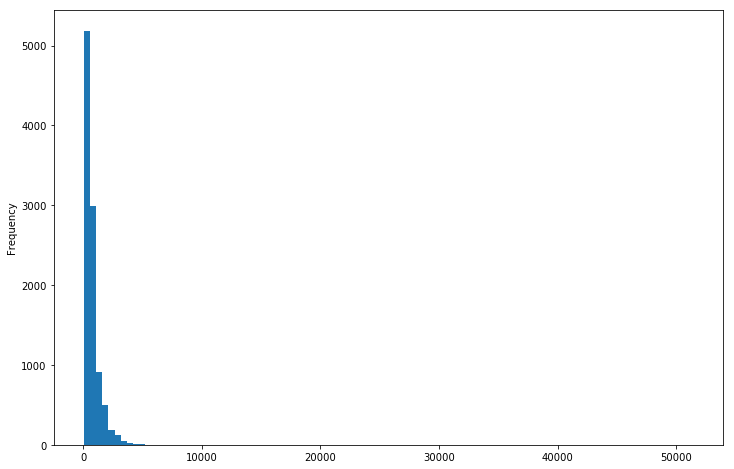

In [116]:
df_tmp = df.copy()
df_tmp = df_tmp[df_tmp.trip_seconds > 0]
seconds = df_tmp.trip_seconds

seconds.sample(10000).plot(kind='hist', bins=100);

Wall time: 487 ms


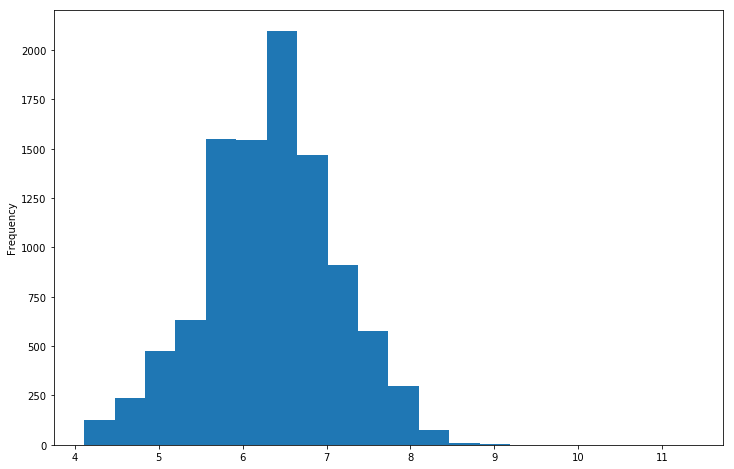

In [136]:
%%time
seconds.sample(10000).apply(lambda x: 
                            np.log(x + 1)).plot(kind='hist', bins=20);

Wall time: 479 ms


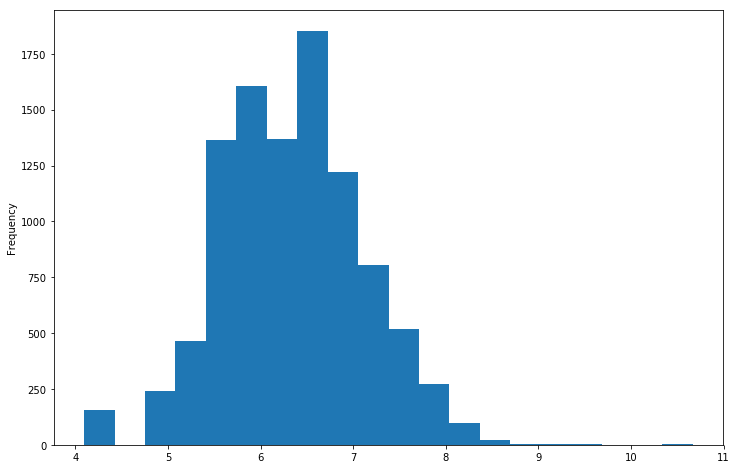

In [137]:
%%time
seconds.sample(10000).apply(lambda x: 
                            np.log(x)).plot(kind='hist', bins=20);

In [179]:
seconds.sort_values()

144693        60.0
1260712       60.0
777663        60.0
777664        60.0
618574        60.0
1260629       60.0
5114          60.0
1659245       60.0
1659239       60.0
1403678       60.0
1659208       60.0
1260522       60.0
5032          60.0
59443         60.0
5014          60.0
1659180       60.0
1403711       60.0
1659042       60.0
1074469       60.0
1050797       60.0
618836        60.0
1050750       60.0
777816        60.0
1260322       60.0
1260742       60.0
1260349       60.0
1260359       60.0
4983          60.0
1050673       60.0
1260400       60.0
            ...   
1521111    84660.0
1049233    84720.0
607594     84780.0
1651952    85020.0
1411278    85200.0
582602     85320.0
272316     85860.0
1839114    85920.0
1595332    85920.0
1534689    86160.0
883378     86280.0
1129542    86340.0
1561255    86340.0
1735283    86340.0
1337435    86340.0
460858     86340.0
1091878    86340.0
1594965    86340.0
1519163    86340.0
1332377    86340.0
30545      86340.0
1709318    8

**<font color='red'>Вопрос №8.</font> Зачем в предыдущей ячейке используется `np.log(x + 1)`, а не просто `np.log`?**

- **чтобы запутать читателей - OK**
- чтобы получить бимодальное распределение
- для скорости вычисления
- во избежание `ValueError`